## install mne as it doesn't come with rsatoolbox

In [1]:
%matplotlib inline
from os.path import join, expanduser, basename
import glob, copy, json
import numpy, tqdm, mne, pandas
import rsatoolbox
from numpy import atleast_2d
from scipy.spatial.distance import pdist
from matplotlib import pyplot
demo_data_dir = './demo_eeg_data/'
epochs_data_dir = expanduser('~/data/imasemrsa/epochs') #TODO

## dataset structure etc

In [14]:
rawdata = expanduser('~/data/imasem/rawdata')
derivdata = expanduser('~/data/imasemrsa/epochs')

fpaths = glob.glob(join(rawdata, '**/*_eeg.bdf'), recursive=True)
for fpath in tqdm.tqdm(fpaths, smoothing=0):
    raw = mne.io.read_raw_bdf(fpath, preload=True, verbose='error')
    chans_fpath = fpath.replace('_eeg.bdf', '_channels.tsv')
    chans_df = pandas.read_csv(chans_fpath, sep='\t')

    # drop unused channels
    misc_chans = chans_df[chans_df.type=='MISC'].name.to_list()
    raw = raw.drop_channels(misc_chans)

    # filter
    raw = raw.filter(l_freq=0.1, h_freq=40, verbose='error')

    # rereference
    ref_chans = chans_df[chans_df.type=='REF'].name.to_list()
    raw.set_eeg_reference(ref_channels=ref_chans, verbose='error')

    # TODO: add nsd labels in event dict?
    events = mne.find_events(raw, verbose='error')
    eeg_chans = chans_df[chans_df.type=='EEG'].name.to_list()
    epochs = mne.Epochs(
        raw,
        events,
        decim=8,
        tmin=-0.2,
        tmax=+1.0,
        picks=eeg_chans,
        verbose='error'
    )
    fname = basename(fpath.replace('_eeg.bdf', '_epo.fif'))
    epochs.save(join(derivdata, fname), verbose='error')

0it [00:00, ?it/s]


# importing data

In [2]:
## loading the epoched data into rsatoolbox
sub = 1
runs = []
for fpath in glob.glob(join(epochs_data_dir, f'sub-0{sub}*task-images*.fif')):
    runs.append(rsatoolbox.io.mne.read_epochs(fpath))

## concatenate runs
dataset = rsatoolbox.data.ops.merge_datasets(runs)

AttributeError: module 'rsatoolbox.io' has no attribute 'mne'

## erp
# bids montage

Not setting metadata
1500 matching events found
Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


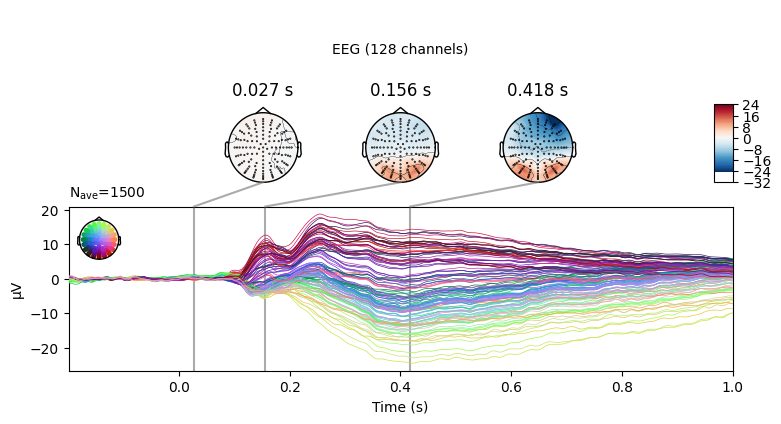

In [27]:
all_epochs = []
for fpath in glob.glob(join(epochs_data_dir, f'sub-0{sub}*task-images*.fif')):
    all_epochs.append(mne.read_epochs(fpath, preload=True, verbose='error'))
grand_avg = mne.concatenate_epochs(all_epochs).average()
grand_avg.set_montage(mne.channels.make_standard_montage('biosemi128'))
grand_avg.plot_joint()
pyplot.close()

## data rdms

In [21]:
#P400
timepoints = dataset.time_descriptors['time']
p400_tps = timepoints[numpy.bitwise_and(timepoints > 0.35, timepoints < 0.45)]
## TODO loop this
ds_bins = dataset.bin_time('time', p400_tps).convert_to_dataset('time')

## calc rdm
data_rdms = rsatoolbox.rdm.calc.calc_rdm_crossnobis(ds_bins, descriptor='triggers')

## annotations

In [22]:
fpaths = glob.glob(join(demo_data_dir, '*_annotations.csv'))
df_raw = pandas.read_csv(fpaths[0])
df = pandas.json_normalize(df_raw.label.apply(json.loads).tolist())
df['animacy'] = df.animacy.str.contains('Yes')
df['indoor'] = df.inoutdoors.str.contains('Indoor')
df['stim'] = df_raw.stim1_name
df.sample(n=7)

,distance,animacy,inoutdoors,color,indoor,stim
92,0.84,True,Outdoor,green,False,shared0318_nsd25112
97,0.69,True,Outdoor,green,False,shared0008_nsd03172
86,0.49,True,Outdoor,red,False,shared0968_nsd70194
99,0.21,True,Outdoor,blue,False,shared0925_nsd66977
44,0.58,False,Outdoor,green,False,shared0857_nsd62210
5,0.14,False,Indoor,red,True,shared0789_nsd56912
56,0.62,True,Outdoor,green,False,shared0589_nsd43690


## model rdms

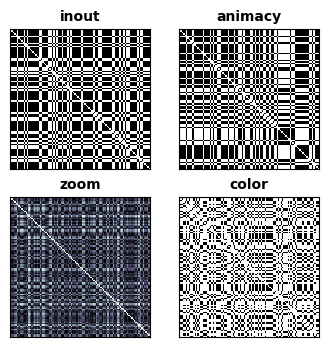

In [23]:
df['r'], df['g'], df['b'] = df.color == 'red', df.color == 'green', df.color == 'blue'
utv_color = pdist(df[['r', 'g', 'b']].values * 1)
utv_zoom = pdist(atleast_2d(df.distance.astype(float)).T)
utv_animacy = pdist(atleast_2d(df.animacy.astype(float)).T)
utv_inout = pdist(atleast_2d(df.indoor.astype(float)).T)
utvs = numpy.asarray([utv_zoom, utv_color, utv_inout, utv_animacy])
utvs /= utvs.max(axis=1, keepdims=True)
model_rdms = rsatoolbox.rdm.rdms.RDMs(
    dissimilarities=utvs,
    dissimilarity_measure='euclidean',
    rdm_descriptors=dict(model_name=['zoom', 'color', 'inout', 'animacy']),
    pattern_descriptors=dict(nds=df.stim)
)
fig, _, _ = rsatoolbox.vis.show_rdm(model_rdms, rdm_descriptor='model_name')
pyplot.show()

## fit model (or instead just evaluate)

In [24]:
annot_model = rsatoolbox.model.ModelWeighted('WeightedAnnotations', model_rdms)
thetas = annot_model.fit(data_rdms, method='cosine')


# TODO plot thetas bar graph or can do this from result?


## create fixed model from MA data
# TODO

## compare models 
#eval_dual_bootstrap[annots+ma] + plot model comparison